In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from importlib import reload
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, GlobalMaxPooling2D, Lambda
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Model
from PIL import Image

In [2]:
IMG_SIZE = (256, 256, 3)

In [3]:
def img_preprocess(imgs):
    imgs = tf.image.resize(imgs, IMG_SIZE[:2], method='bilinear')
    return imgs

def model_preprocess(x):
    x = Rescaling(1/255)(x)
    return x

def make_model(input_shape):
    base_model = ResNet50(include_top=False, pooling=None, weights=None,
                          input_shape=input_shape)
    
    inputs = Input(shape=input_shape)
    x = model_preprocess(inputs)
    x = base_model(x)
    x = Lambda(lambda x: x, name='lambda_1')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
model = make_model(IMG_SIZE)
model.build(IMG_SIZE)
model.load_weights('FSL_ResNet50_XrayRemix.h5')
model.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
lambda_1 (Lambda)            (None, 8, 8, 2048)        0         
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192  

In [5]:
img_files = ['BACTERIA-7422-0001.jpeg', 'BACTERIA-30629-0001.jpeg',
             'NORMAL-28501-0001.jpeg', 'NORMAL-32326-0001.jpeg']

((800, 1119, 3), 0, 255)

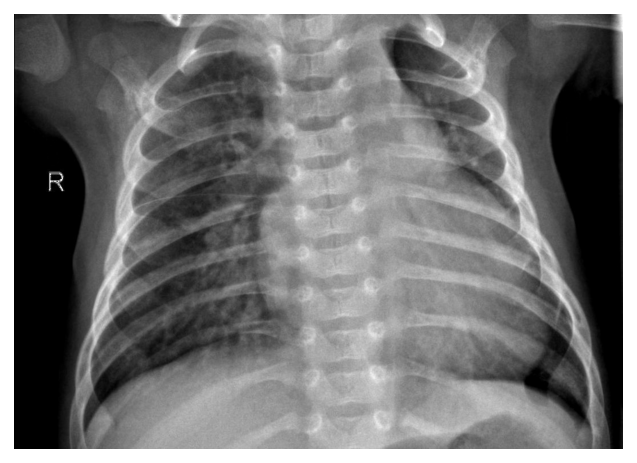

In [6]:
img_idx = 0
fname = img_files[img_idx]
img = np.array(Image.open('static/' + fname))
if len(img.shape) == 2:
    img = np.stack([img] * 3, axis=-1)
plt.axis('off'); plt.imshow(img);
img.shape, img.min(), img.max()

In [7]:
batch = np.expand_dims(img, axis=0)
batch_t = img_preprocess(batch)
pred = model.predict(batch_t)
print(f'{fname} ==> {pred[0][0]:.3f}')

BACTERIA-7422-0001.jpeg ==> 0.950


In [8]:
# Create Grad-CAM heatmap of single image
def make_gradcam_heatmap(img_batch, model, last_conv_layer, pred_index):
    assert len(img_batch.shape) == 4 and img_batch.shape[0] == 1
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    if isinstance(last_conv_layer, str):
        last_conv_layer = model.get_layer(last_conv_layer)
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv_layer.output, model.output]
    )

    # Grad-CAM requires model's output to be logits
    last_activation = model.layers[-1].activation
    model.layers[-1].activation = None

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_batch)
        if pred_index is None:  # then pick the highest-probability class
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Restore model's output activation
    model.layers[-1].activation = last_activation

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

((8, 8), 0.0, 1.0)

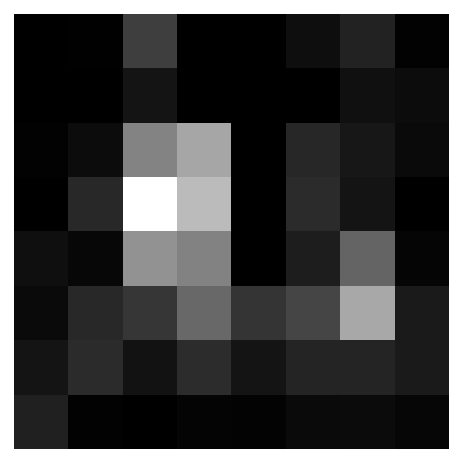

In [9]:
heatmap = make_gradcam_heatmap(batch_t, model, 'lambda_1', 0)
plt.axis('off'); plt.imshow(heatmap, cmap='gray');
heatmap.shape, heatmap.min(), heatmap.max()

## Grayscale Heatmap

(800, 1119, 3) -0.0215271 0.9231291


(TensorShape([800, 1119, 3]), 0.0, 0.9231291)

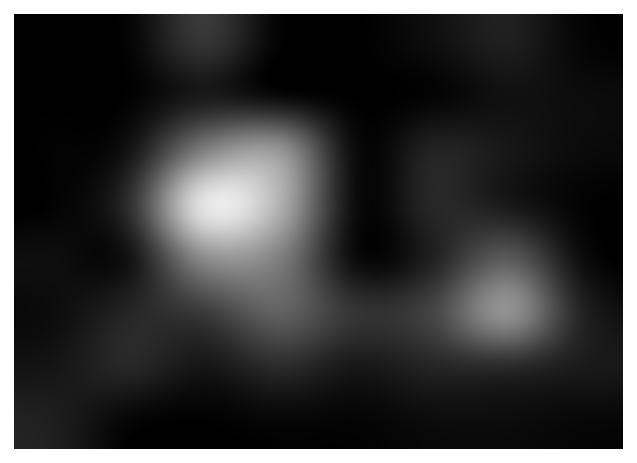

In [10]:
heatmap_rgb = np.stack([heatmap] * 3, axis=-1)
heatmap_rsg = tf.image.resize(heatmap_rgb, img.shape[:2], tf.image.ResizeMethod.MITCHELLCUBIC)
print(heatmap_rsg.shape, tf.reduce_min(heatmap_rsg).numpy(), tf.reduce_max(heatmap_rsg).numpy())
heatmap_rsg = tf.clip_by_value(heatmap_rsg, 0.0, 1.0)
plt.axis('off'); plt.imshow(heatmap_rsg)
heatmap_rsg.shape, tf.reduce_min(heatmap_rsg).numpy(), tf.reduce_max(heatmap_rsg).numpy()

0.05 1.1115984
0.0 166.1508


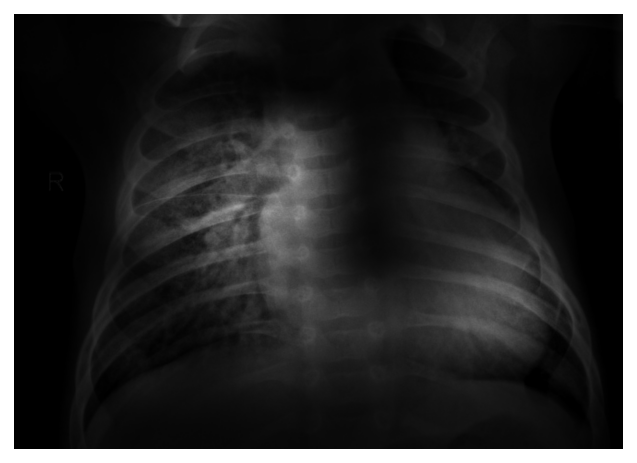

In [11]:
heatmap_rsg = heatmap_rsg * 1.15 + 0.05
print(tf.reduce_min(heatmap_rsg).numpy(), tf.reduce_max(heatmap_rsg).numpy())
superimp_g = heatmap_rsg * img
print(tf.reduce_min(superimp_g).numpy(), tf.reduce_max(superimp_g).numpy())
superimp_g = tf.cast(tf.clip_by_value(superimp_g, 0.0, 255.0), tf.uint8)
tf.io.write_file('saliency-gray.jpeg', tf.io.encode_jpeg(superimp_g))
plt.axis('off'); plt.imshow(superimp_g);

## Color Heatmap

In [12]:
jet_colors = np.load('jet_colors.npy')
jet_colors.shape, jet_colors.min(), jet_colors.max()

((256, 3), 0.000, 1.000)

((8, 8, 3), 0.000, 1.000)

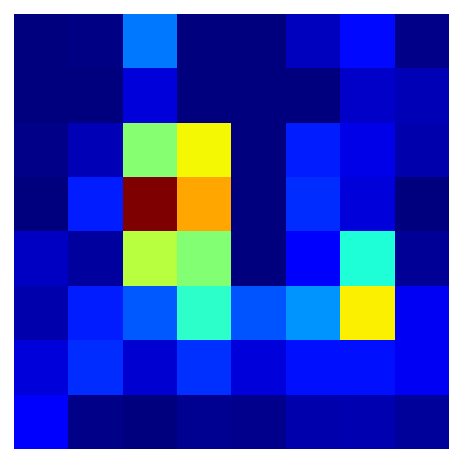

In [13]:
heatmap_ui8 = np.uint8(255 * heatmap)
heatmap_jet = jet_colors[heatmap_ui8]
plt.axis('off'); plt.imshow(heatmap_jet)
heatmap_jet.shape, heatmap_jet.min(), heatmap_jet.max()

(800, 1119, 3) -0.07195965 1.0449547


(TensorShape([800, 1119, 3]), 0.0, 1.0)

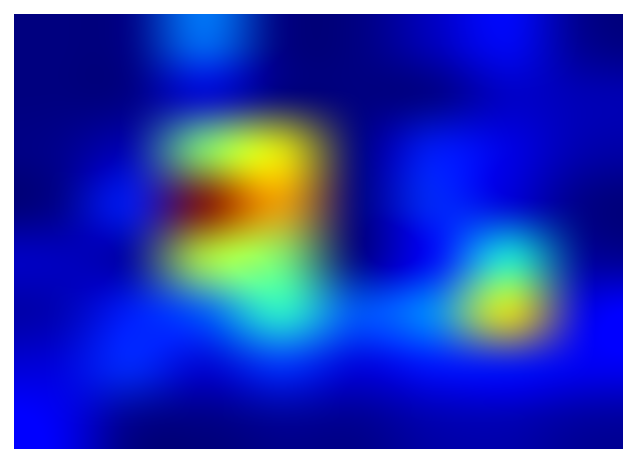

In [14]:
heatmap_rsc = tf.image.resize(heatmap_jet, img.shape[:2], tf.image.ResizeMethod.MITCHELLCUBIC)
print(heatmap_rsc.shape, tf.reduce_min(heatmap_rsc).numpy(), tf.reduce_max(heatmap_rsc).numpy())
heatmap_rsc = tf.clip_by_value(heatmap_rsc, 0.0, 1.0)
plt.axis('off'); plt.imshow(heatmap_rsc)
heatmap_rsc.shape, tf.reduce_min(heatmap_rsc).numpy(), tf.reduce_max(heatmap_rsc).numpy()

0.0 1.0054696


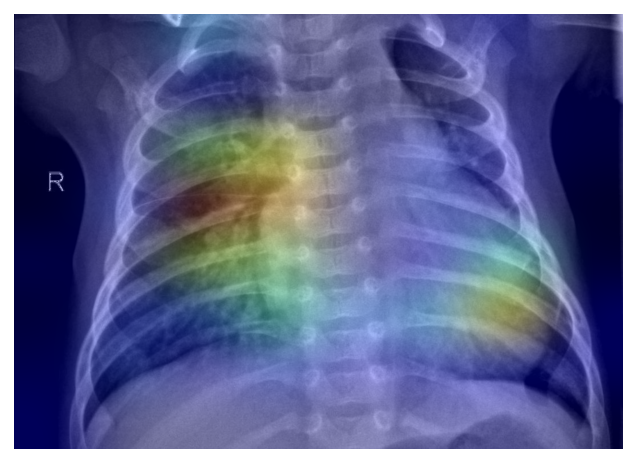

In [15]:
alpha, beta = 0.35, 0.7
superimp_c = heatmap_rsc * alpha + img/255 * beta
print(tf.reduce_min(superimp_c).numpy(), tf.reduce_max(superimp_c).numpy())
superimp_c = tf.cast(tf.clip_by_value(superimp_c * 255, 0.0, 255.0), tf.uint8)
tf.io.write_file('saliency-color.jpeg', tf.io.encode_jpeg(superimp_c))
plt.axis('off'); plt.imshow(superimp_c);